In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
rruff_db = pd.read_csv('rruff_database_2021_12_25.csv',
                           index_col='Mineral Name',
                           dtype=str,
                           na_filter=False
                          ).transpose()

In [3]:
stages = [ '1', '2', '3a', '3b', '4a', '4b', '5', '7', '10a', '10b' ]
rruff_db_stages = {
    s: pd.read_csv(f'rruff_database_2021_12_25_S{s}.csv',
                       index_col='Mineral Name',
                       dtype=str,
                       na_filter=False
                      ).transpose()
    for s in stages
}
            
# determine all the minerals present in each stage
minerals_present_in_stage = {
    stage: [ mineral for mineral in rruff_db_stages[stage].keys() ]
    for stage in stages
}

# determine which stage a mineral first appeared in
stages_where_minerals_first_appeared = {}
for mineral in rruff_db.keys():
    for stage in stages:
        if mineral in rruff_db_stages[stage].keys():
            stages_where_minerals_first_appeared[mineral] = stage
            break

# determine all the minerals that first appeared in each stage
minerals_first_appeared_in_stage = {
    stage: [ mineral for mineral, stg in stages_where_minerals_first_appeared.items() if stg == stage ]
    for stage in stages
}

In [4]:
symmetry_indices = {
    'amorphous': 0,
    'triclinic': 1,
    'monoclinic': 2,
    'orthorhombic': 3,
    'trigonal': 4,
    'tetragonal': 5,
    'hexagonal': 6,
    'cubic': 7
}

no_crystal_system = ''
# calculate the symmetry index of each stage based on the minerals that first appeared in each stage
stage_symmetry_indices_appeared = []
stage_species_appeared_populations = []
for stage, minerals_appeared in minerals_first_appeared_in_stage.items():
    stage_symmetry_index = 0
    stage_population = { crystal_system: 0 for crystal_system in symmetry_indices.keys() }
    for mineral in minerals_appeared:
        crystal_systems = rruff_db_stages[stage][mineral]['Crystal Systems']
        for crystal_system in crystal_systems.replace(', ', '|').split('|'):
            if crystal_system in symmetry_indices.keys():
                stage_symmetry_index += symmetry_indices[crystal_system]
                stage_population[crystal_system] += 1
            else:
                no_crystal_system += f'S{stage} - {mineral}: {crystal_system}\n'
                
    stage_symmetry_indices_appeared.append(
        stage_symmetry_index / symmetry_indices['cubic'] / len(minerals_appeared)
    )
    stage_species_appeared_populations.append(stage_population)
            
n_minerals_appeared_in_stage = [ sum(stage_pop.values()) for stage_pop in stage_species_appeared_populations ]
stage_species_appeared_populations = pd.DataFrame(stage_species_appeared_populations)
stage_species_appeared_populations.index = stages
stage_species_appeared_populations_pct = (
    stage_species_appeared_populations.transpose()/n_minerals_appeared_in_stage*100
).transpose()

with open('no_crystal_system.txt', 'w') as f:
    f.write(no_crystal_system)
    
# calculate the symmetry index of each stage based on the minerals present in each stage
stage_symmetry_indices_present = []
stage_species_present_populations = []
for stage, minerals_present in minerals_present_in_stage.items():
    stage_symmetry_index = 0
    stage_population = { crystal_system: 0 for crystal_system in symmetry_indices.keys() }
    for mineral in minerals_present:
        crystal_systems = rruff_db_stages[stage][mineral]['Crystal Systems']
        for crystal_system in crystal_systems.replace(', ', '|').split('|'):
            if crystal_system in symmetry_indices.keys():
                stage_symmetry_index += symmetry_indices[crystal_system]
                stage_population[crystal_system] += 1
                
    stage_symmetry_indices_present.append(
        stage_symmetry_index / symmetry_indices['cubic'] / len(minerals_present)
    )
    stage_species_present_populations.append(stage_population)
    
n_minerals_present_in_stage = [ sum(stage_pop.values()) for stage_pop in stage_species_present_populations ]
stage_species_present_populations = pd.DataFrame(stage_species_present_populations)
stage_species_present_populations.index = stages
stage_species_present_populations_pct = (
    stage_species_present_populations.transpose()/n_minerals_present_in_stage*100
).transpose()
    
# calculate the cumulative symmetry index of each stage based on all the minerals that
# appeared in that stage and all previous ones
stage_symmetry_indices_cumulative = []
n_species_cumulative = []
for i in range(len(stages)):
    symmetry_index_cumulative_count = 0
    n_species = 0
    for j in range(i+1):
        minerals_in_stage = n_minerals_appeared_in_stage[j]
        symmetry_index_cumulative_count += stage_symmetry_indices_appeared[j] * minerals_in_stage
        n_species += minerals_in_stage
        
    n_species_cumulative.append(n_species)
    stage_symmetry_indices_cumulative.append(symmetry_index_cumulative_count/n_species)

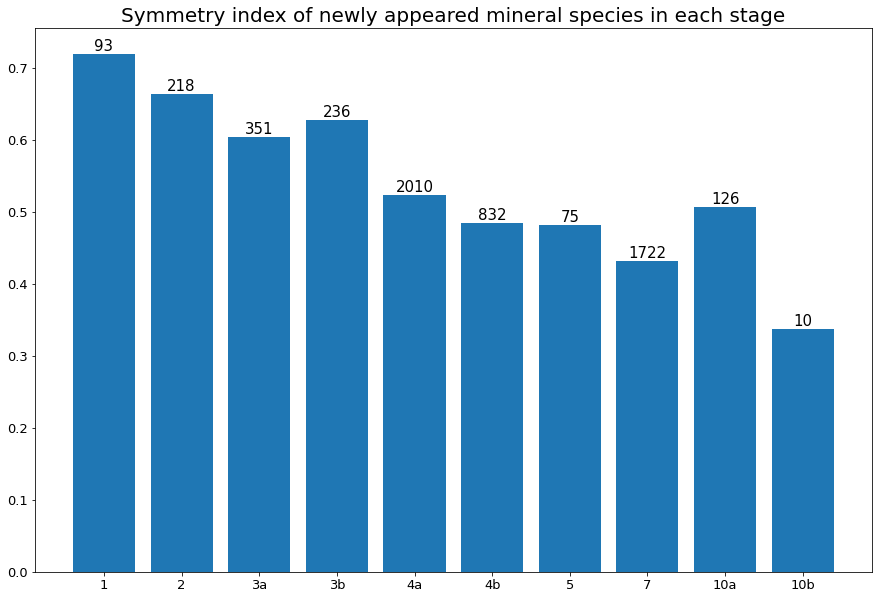

In [5]:
plt.figure(figsize=(15, 10))
bars = plt.bar(range(len(stages)), stage_symmetry_indices_appeared)
plt.xticks(range(len(stages)), labels=stages, fontsize=13)
plt.yticks(fontsize=13)
plt.title('Symmetry index of newly appeared mineral species in each stage', fontsize=20)

for n_minerals, bar in zip(n_minerals_appeared_in_stage, bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{n_minerals}',
             ha='center', va='bottom', fontsize=15
            )

plt.savefig('graph_first_appeared.png')

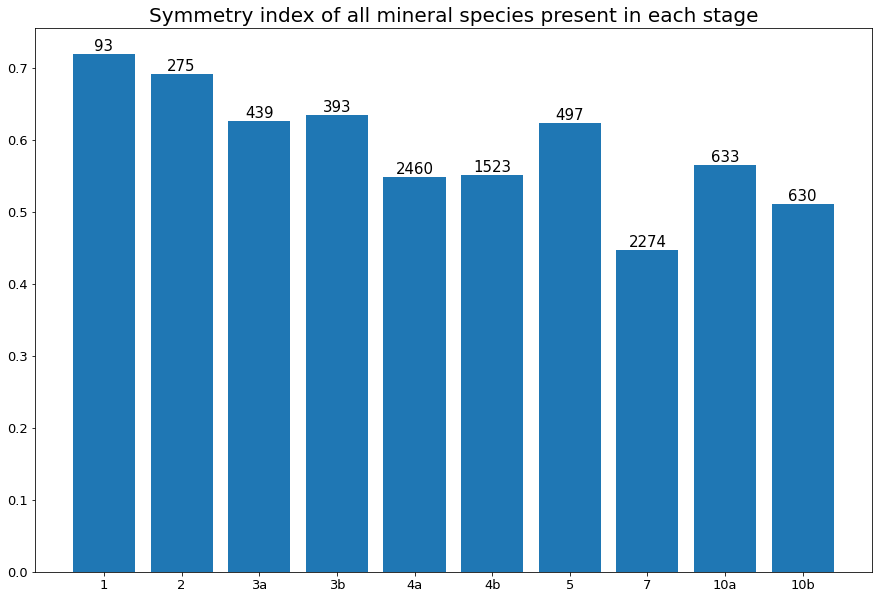

In [6]:
plt.figure(figsize=(15, 10))
bars = plt.bar(range(len(stages)), stage_symmetry_indices_present)
plt.xticks(range(len(stages)), labels=stages, fontsize=13)
plt.yticks(fontsize=13)
plt.title('Symmetry index of all mineral species present in each stage', fontsize=20)

for n_minerals, bar in zip(n_minerals_present_in_stage, bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{n_minerals}',
             ha='center', va='bottom', fontsize=15
            )
    
plt.savefig('graph_present.png')

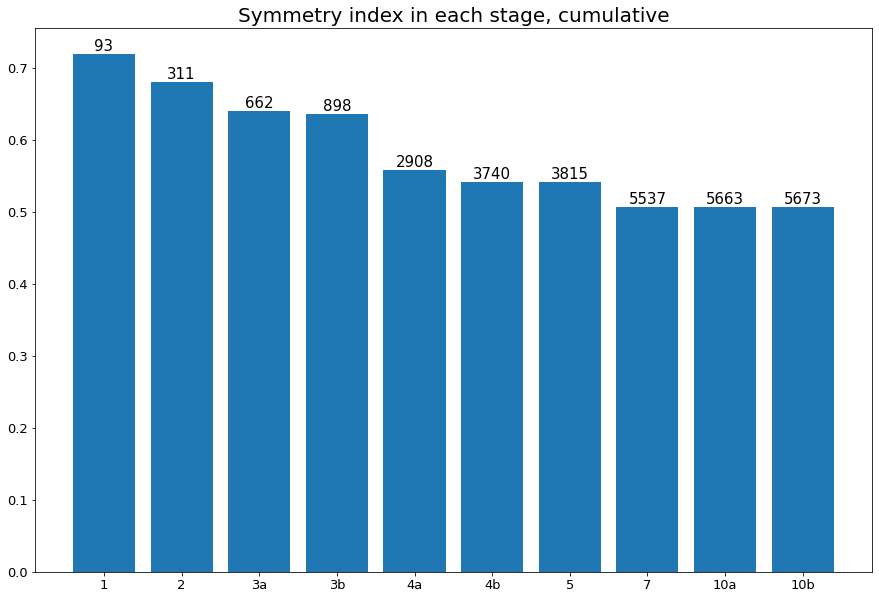

In [7]:
plt.figure(figsize=(15, 10))
bars = plt.bar(range(len(stages)), stage_symmetry_indices_cumulative)
plt.xticks(range(len(stages)), labels=stages, fontsize=13)
plt.yticks(fontsize=13)
plt.title('Symmetry index in each stage, cumulative', fontsize=20)

for n_minerals, bar in zip(n_species_cumulative, bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{n_minerals}',
             ha='center', va='bottom', fontsize=15
            )
    
plt.savefig('graph_cumulative.png')

In [8]:
stage_species_appeared_populations

,amorphous,triclinic,monoclinic,orthorhombic,trigonal,tetragonal,hexagonal,cubic
1,1,7,19,14,0,8,22,22
2,0,17,50,40,1,15,52,43
3a,1,18,113,73,3,29,65,49
3b,1,15,75,31,0,39,38,37
4a,5,183,652,440,6,163,370,191
4b,4,91,315,159,3,31,177,52
5,0,4,31,16,0,1,17,6
7,7,274,636,339,1,109,267,89
10a,0,11,40,32,0,8,28,7
10b,0,2,6,0,0,0,2,0


In [9]:
stage_species_present_populations

,amorphous,triclinic,monoclinic,orthorhombic,trigonal,tetragonal,hexagonal,cubic
1,1,7,19,14,0,8,22,22
2,0,20,57,49,1,22,67,59
3a,1,28,130,90,4,37,81,68
3b,2,29,121,62,4,47,70,58
4a,7,212,785,513,10,207,457,269
4b,8,136,506,283,6,96,326,162
5,0,39,161,80,5,27,113,72
7,8,328,835,460,3,142,369,129
10a,4,59,197,126,3,43,130,71
10b,4,82,227,110,2,44,102,59


In [10]:
stage_species_appeared_populations_pct

,amorphous,triclinic,monoclinic,orthorhombic,trigonal,tetragonal,hexagonal,cubic
1,1.075269,7.526882,20.430108,15.053763,0.000000,8.602151,23.655914,23.655914
2,0.000000,7.798165,22.935780,18.348624,0.458716,6.880734,23.853211,19.724771
3a,0.284900,5.128205,32.193732,20.797721,0.854701,8.262108,18.518519,13.960114
3b,0.423729,6.355932,31.779661,13.135593,0.000000,16.525424,16.101695,15.677966
4a,0.248756,9.104478,32.437811,21.890547,0.298507,8.109453,18.407960,9.502488
4b,0.480769,10.937500,37.860577,19.110577,0.360577,3.725962,21.274038,6.250000
5,0.000000,5.333333,41.333333,21.333333,0.000000,1.333333,22.666667,8.000000
7,0.406504,15.911731,36.933798,19.686411,0.058072,6.329849,15.505226,5.168409
10a,0.000000,8.730159,31.746032,25.396825,0.000000,6.349206,22.222222,5.555556
10b,0.000000,20.000000,60.000000,0.000000,0.000000,0.000000,20.000000,0.000000


In [11]:
stage_species_present_populations_pct

,amorphous,triclinic,monoclinic,orthorhombic,trigonal,tetragonal,hexagonal,cubic
1,1.075269,7.526882,20.430108,15.053763,0.000000,8.602151,23.655914,23.655914
2,0.000000,7.272727,20.727273,17.818182,0.363636,8.000000,24.363636,21.454545
3a,0.227790,6.378132,29.612756,20.501139,0.911162,8.428246,18.451025,15.489749
3b,0.508906,7.379135,30.788804,15.776081,1.017812,11.959288,17.811705,14.758270
4a,0.284553,8.617886,31.910569,20.853659,0.406504,8.414634,18.577236,10.934959
4b,0.525279,8.929744,33.223900,18.581747,0.393959,6.303349,21.405121,10.636901
5,0.000000,7.847082,32.394366,16.096579,1.006036,5.432596,22.736419,14.486922
7,0.351803,14.423923,36.719437,20.228672,0.131926,6.244503,16.226913,5.672823
10a,0.631912,9.320695,31.121643,19.905213,0.473934,6.793049,20.537125,11.216430
10b,0.634921,13.015873,36.031746,17.460317,0.317460,6.984127,16.190476,9.365079


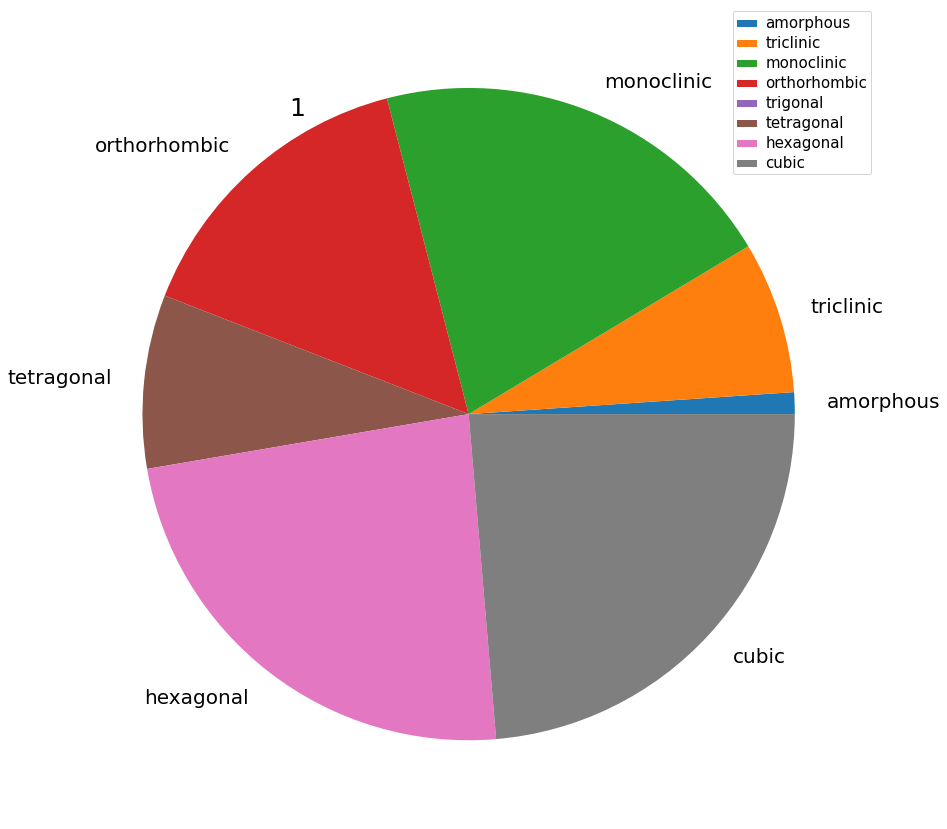

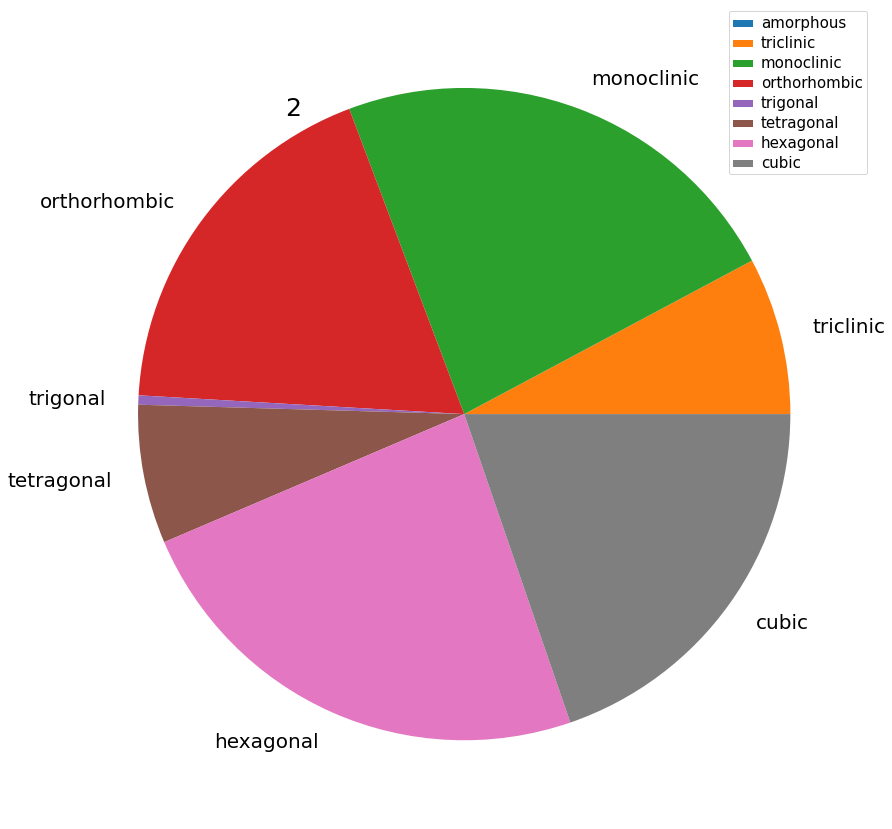

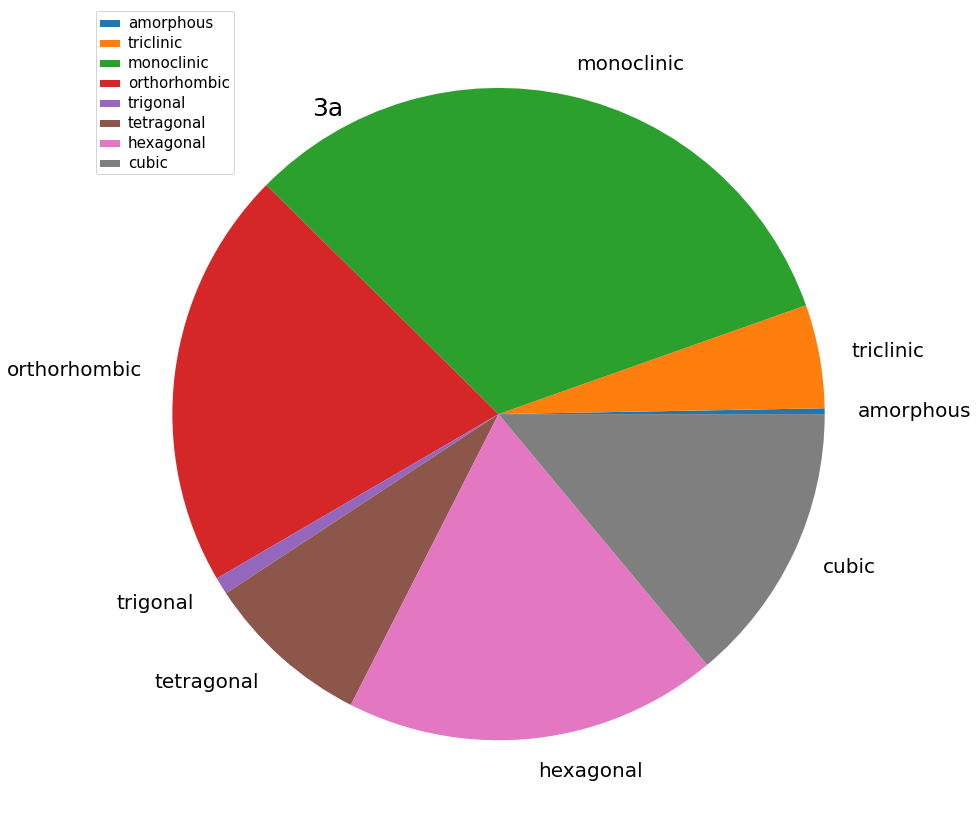

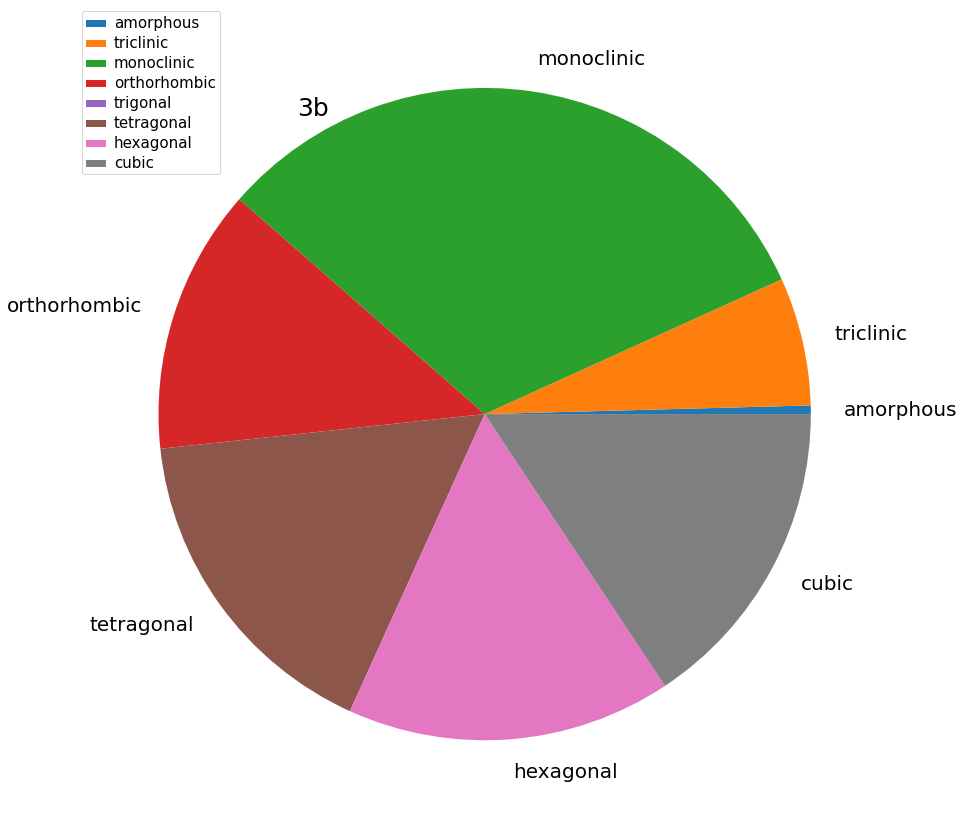

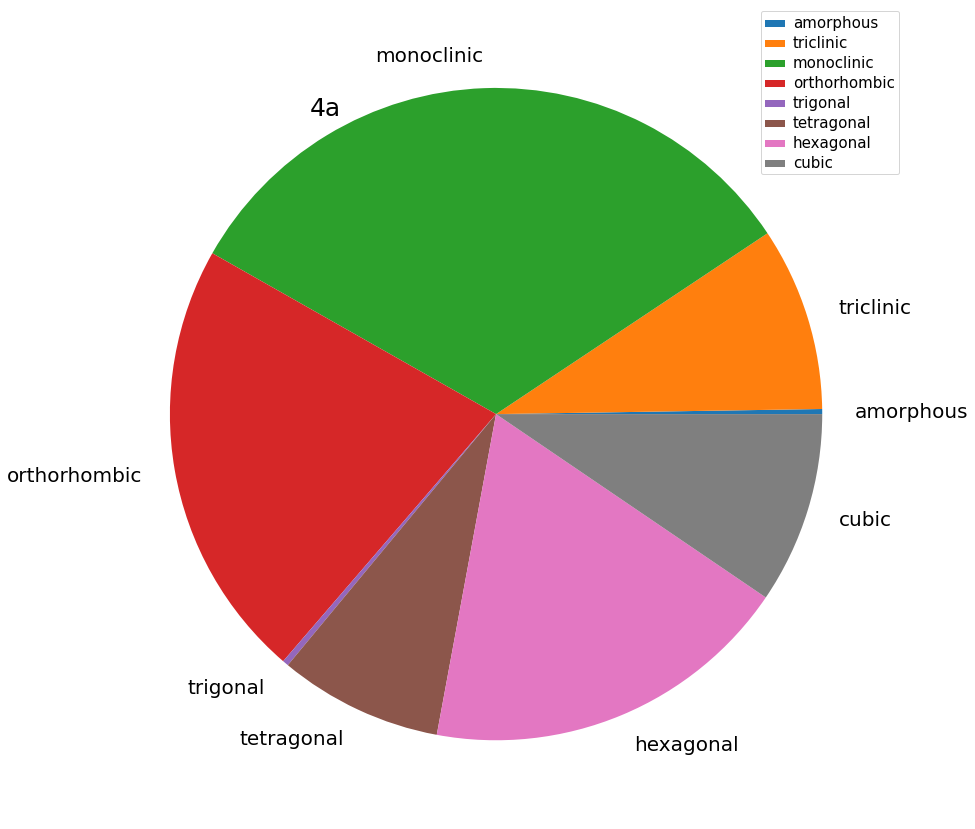

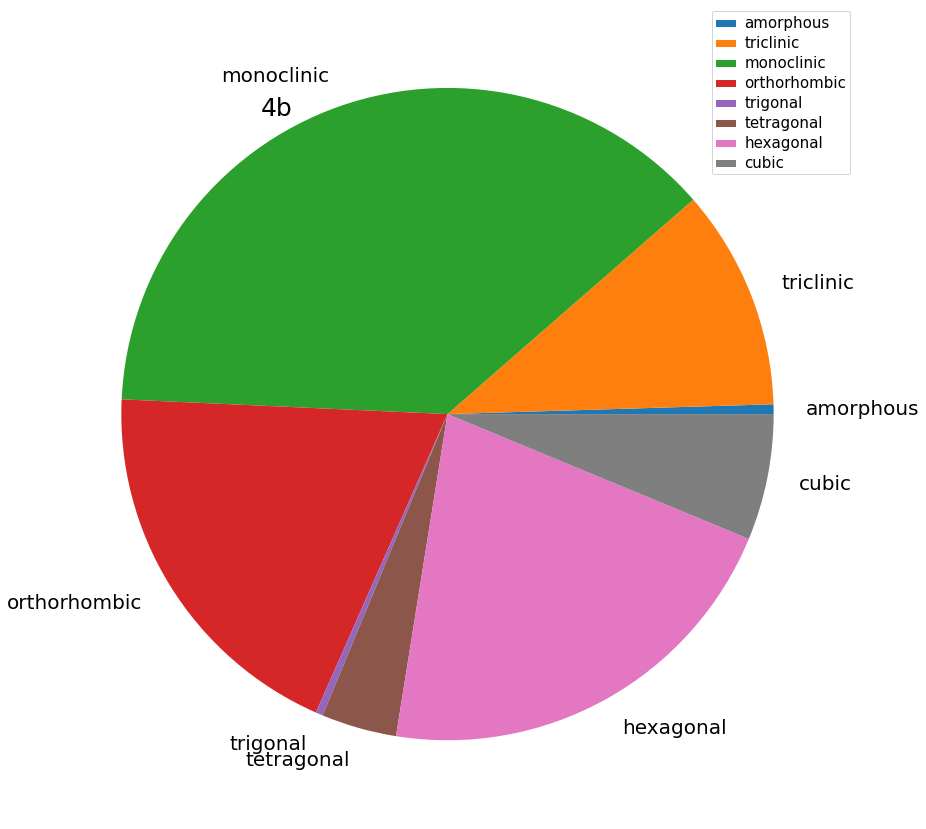

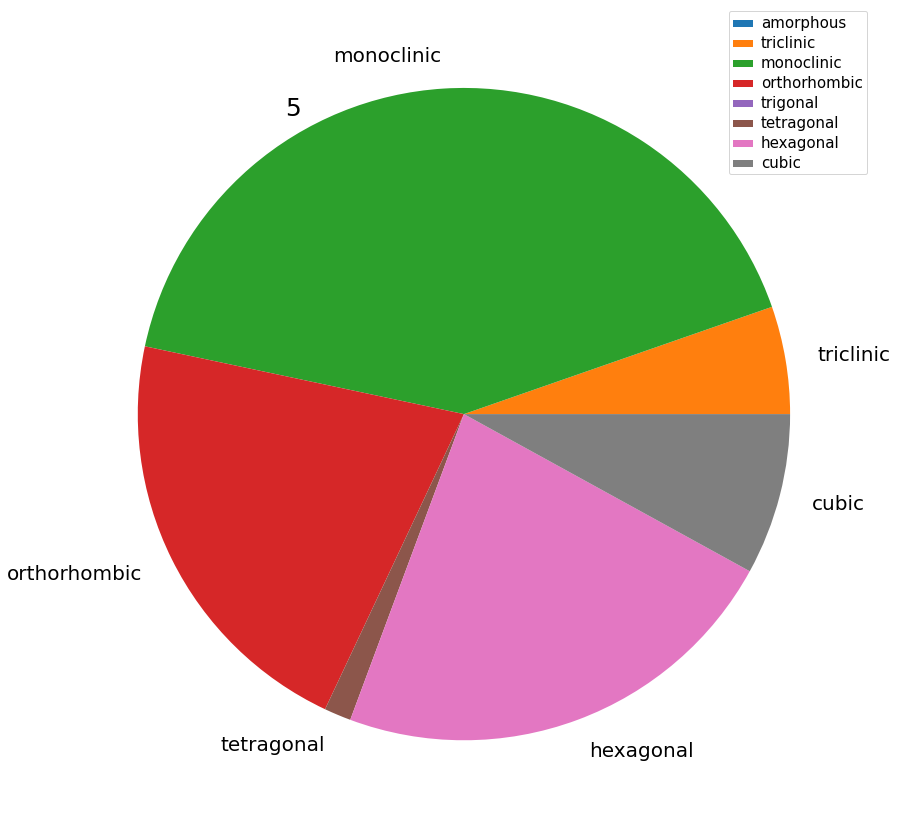

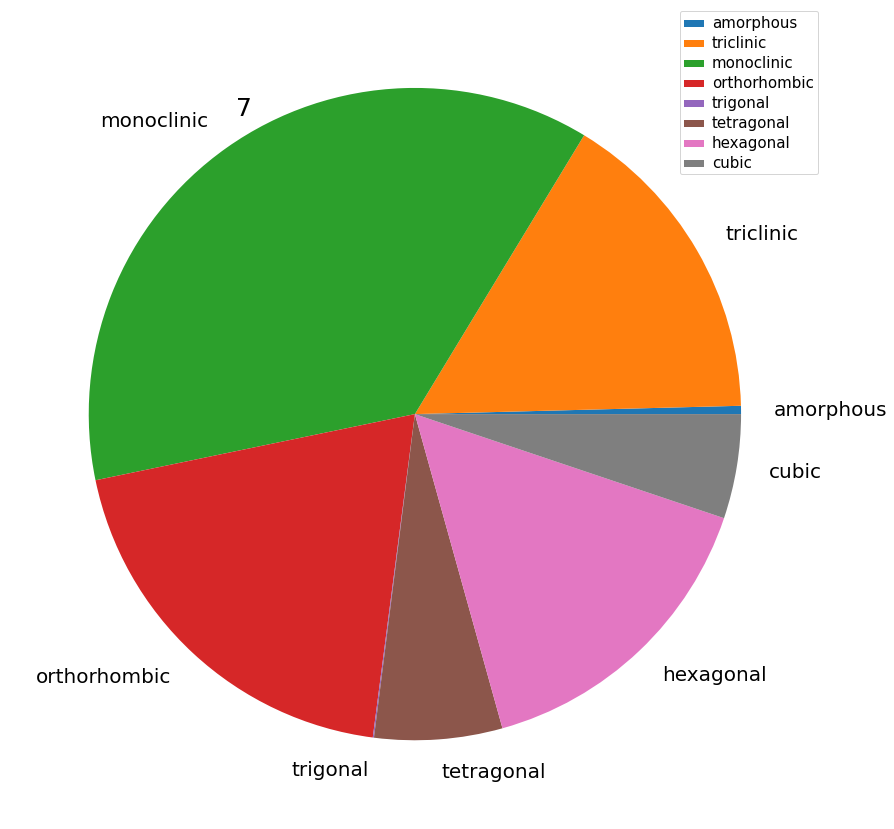

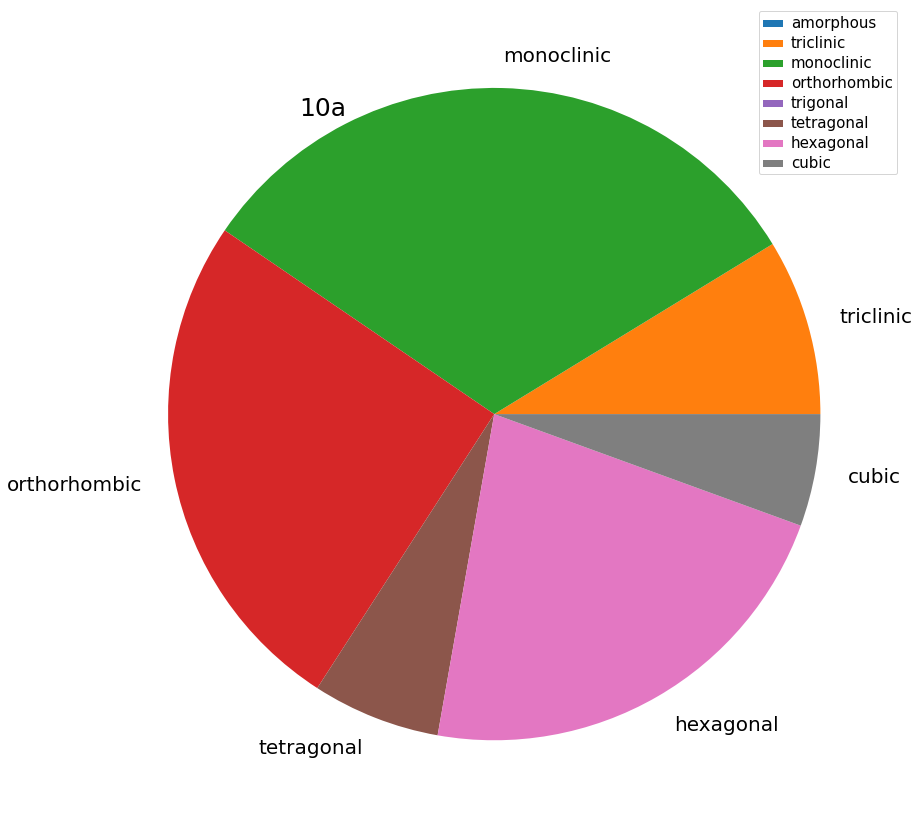

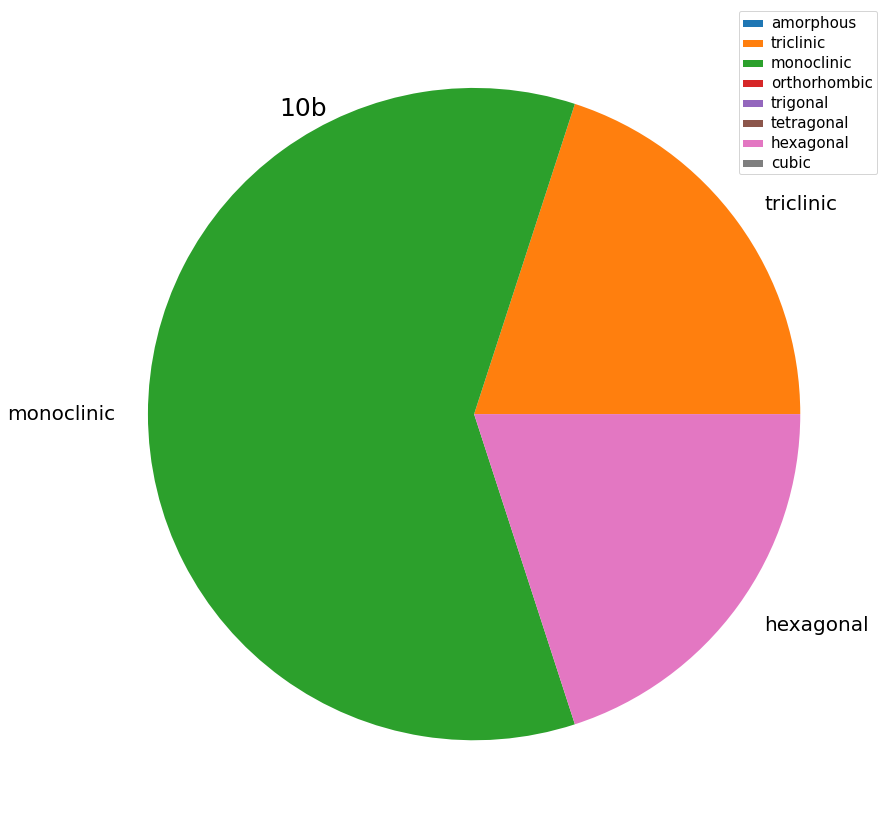

In [12]:
for stage in stages:
    fig = stage_species_appeared_populations.transpose().plot.pie(y=stage, figsize=(15, 15), fontsize=20)
    y_label = fig.axes.set_ylabel(stage, fontsize=25)
    y_label.set_rotation(0)
    fig.axes.yaxis.set_label_coords(0.29, 0.86)
    
    legend = fig.axes.get_legend()
    
    for text in legend.get_texts():
        text.set_fontsize(15)
        
    fig.get_figure().savefig(f'population_S{stage}.png')